# Chapter 19: Training and Deploying TensorFlow Models at Scale
# Training dan Deployment Model TensorFlow pada Skala Besar

## Pengantar

Chapter ini membahas aspek praktis dari deployment model machine learning 
dalam production environment dan training model pada skala besar.

**Topik yang dibahas:**
- Model serving dan deployment strategies
- TensorFlow Serving
- TensorFlow Lite untuk mobile dan edge devices
- Distributed training
- Model optimization dan quantization
- Monitoring dan maintenance
- MLOps best practices

**Tantangan Production:**
- Scalability dan performance
- Model versioning
- A/B testing
- Data drift detection
- Security considerations
- Cost optimization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import json
import requests

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


---

# 🚀 1. Model Deployment dengan TensorFlow Serving

## 📖 **TensorFlow Serving Overview**

**TensorFlow Serving** adalah sistem yang dirancang khusus untuk deployment model TensorFlow dalam production environment.

### **🎯 Fitur Utama TF Serving:**
- **High-performance serving** dengan optimasi khusus
- **Model versioning** dan automatic loading
- **Multiple model support** dalam satu server
- **gRPC dan REST API** endpoints
- **Request batching** untuk throughput tinggi
- **Model warmup** untuk latency rendah

### **📊 Arsitektur TF Serving:**
```
Client Request → TF Serving → Model Manager → Model Loader → Inference
```

### **🔧 Deployment Strategy:**
1. **Development**: Train model dengan tf.keras
2. **Export**: Simpan sebagai SavedModel
3. **Serve**: Deploy dengan TF Serving
4. **Monitor**: Performance dan health metrics

---

## 📦 **SavedModel Format**

**SavedModel** adalah format standar TensorFlow untuk model deployment:

In [5]:
# =============================================================================
# 📦 1.1 CREATING AND EXPORTING SAVEDMODEL
# =============================================================================

print("🚀 Creating and Exporting SavedModel")
print("=" * 50)

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Preprocessing
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Create model with Input layer (Keras 3.x compatibility)
model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28), name="input"),
    keras.layers.Flatten(name="flatten_input"),
    keras.layers.Dense(100, activation="relu", name="hidden1"),
    keras.layers.Dense(50, activation="relu", name="hidden2"),
    keras.layers.Dense(10, activation="softmax", name="output")
], name="mnist_classifier")

# Compile model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(f"\nModel architecture:")
model.summary()

# Train model (quick training for demo)
print(f"\n🎯 Training model...")
history = model.fit(
    X_train[:5000], y_train[:5000],  # Use subset for quick demo
    epochs=3,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Export model to SavedModel format (Keras 3.x method)
model_name = "my_mnist_model"
model_version = "0001"
model_path = os.path.join(model_name, model_version)

# Use model.export() for Keras 3.x SavedModel export
try:
    model.export(model_path)
    print(f"\n✅ Model exported to: {model_path}")
except AttributeError:
    # Fallback: save as .keras and show message
    keras_path = os.path.join(model_name, "model.keras")
    os.makedirs(model_name, exist_ok=True)
    model.save(keras_path)
    print(f"\n✅ Model saved as Keras format: {keras_path}")
    print("💡 Note: For TF Serving, convert this to SavedModel format in production")
    model_path = keras_path

# Verify export
if os.path.exists(model_path):
    print(f"📁 SavedModel structure:")
    for root, dirs, files in os.walk(model_path):
        level = root.replace(model_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")
else:
    print("❌ Model export failed!")

print("\n✅ SavedModel export completed!")

🚀 Creating and Exporting SavedModel
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)

Model architecture:


Model: "mnist_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_input (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,060 (328.36 KB)

 Trainable params: 84,060 (328.36 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Training model...
Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4394 - loss: 1.8409 - val_accuracy: 0.8490 - val_loss: 0.6360
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8763 - loss: 0.5059 - val_accuracy: 0.8870 - val_loss: 0.4037
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9112 - loss: 0.3380 - val_accuracy: 0.9140 - val_loss: 0.3397

📊 Test Results:
Test Accuracy: 0.8969
Test Loss: 0.3619
INFO:tensorflow:Assets written to: my_mnist_model\0001\assets


INFO:tensorflow:Assets written to: my_mnist_model\0001\assets


Saved artifact at 'my_mnist_model\0001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2708845965200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2708845965968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2708845965776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2708845964048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2708845966544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2708845966160: TensorSpec(shape=(), dtype=tf.resource, name=None)

✅ Model exported to: my_mnist_model\0001
📁 SavedModel structure:
0001/
  fingerprint.pb
  saved_model.pb
  assets/
  variables/
    variables.data-00000-of-00001
    variables.index

✅ SavedModel export completed!


---

## 🔍 **1.2 Loading dan Testing SavedModel**

### **📝 SavedModel Components:**
- **Assets**: Additional files (vocabularies, lookup tables)
- **saved_model.pb**: Computation graph dan metadata
- **Variables**: Model weights dan parameters
- **Signatures**: Definisi input/output untuk serving

### **🔧 Loading Methods:**
1. **tf.saved_model.load()**: Raw TensorFlow function
2. **keras.models.load_model()**: Keras model object

In [7]:
# =============================================================================
# 🔍 1.2 LOADING AND TESTING SAVEDMODEL
# =============================================================================

print("🔍 Loading and Testing SavedModel")
print("=" * 50)

# Method 1: Load as TensorFlow function
print("📥 Method 1: tf.saved_model.load()")
try:
    saved_model = tf.saved_model.load(model_path)
    print("✅ SavedModel loaded successfully")
    
    # Test prediction with proper signature call
    X_sample = X_test[:3]  # 3 test samples
    
    # Use serving_default signature
    inference_func = saved_model.signatures['serving_default']
    y_pred_tf = inference_func(input=tf.constant(X_sample, dtype=tf.float32))['output_0']
    
    print(f"Input shape: {X_sample.shape}")
    print(f"Prediction shape: {y_pred_tf.shape}")
    print(f"Predicted classes: {np.argmax(y_pred_tf.numpy(), axis=1)}")
    print(f"True classes: {y_test[:3]}")
    
except Exception as e:
    print(f"❌ Error loading SavedModel: {e}")

print("\n" + "-" * 50)

# Method 2: Load with TFSMLayer (Keras 3.x method)
print("📥 Method 2: keras.layers.TFSMLayer() for Keras 3.x")
try:
    # Use TFSMLayer as recommended for Keras 3.x
    tfsm_layer = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')
    print("✅ TFSMLayer loaded successfully")
    
    # Test prediction with TFSMLayer
    y_pred_tfsm = tfsm_layer(tf.constant(X_sample, dtype=tf.float32))
    
    print(f"TFSMLayer prediction shape: {y_pred_tfsm.shape}")
    print(f"Predicted classes: {np.argmax(y_pred_tfsm.numpy(), axis=1)}")
    
    # Compare predictions
    print(f"\nPrediction comparison:")
    print(f"SavedModel: {np.round(y_pred_tf.numpy(), 3)}")
    print(f"TFSMLayer:  {np.round(y_pred_tfsm.numpy(), 3)}")
    print(f"Predictions match: {np.allclose(y_pred_tf.numpy(), y_pred_tfsm.numpy())}")
    
except Exception as e:
    print(f"❌ Error loading with TFSMLayer: {e}")

print("\n" + "-" * 50)

# Method 3: Direct model prediction for comparison
print("📥 Method 3: Original Model Prediction")
try:
    y_pred_original = model.predict(X_sample, verbose=0)
    print(f"Original model prediction shape: {y_pred_original.shape}")
    print(f"Predicted classes: {np.argmax(y_pred_original, axis=1)}")
    
    if 'y_pred_tf' in locals():
        print(f"\nOriginal vs SavedModel predictions match: {np.allclose(y_pred_original, y_pred_tf.numpy(), atol=1e-5)}")
    
except Exception as e:
    print(f"❌ Error with original model: {e}")

print("\n" + "-" * 50)

# Inspect SavedModel signatures
print("🔍 Inspecting SavedModel Signatures:")
try:
    print("Available signatures:")
    print(list(saved_model.signatures.keys()))
    
    if 'serving_default' in saved_model.signatures:
        serving_default = saved_model.signatures['serving_default']
        print(f"\nServing signature info:")
        print(f"Function: {serving_default}")
        
        # Input signature
        print(f"\nInput signature:")
        structured_input = serving_default.structured_input_signature
        if len(structured_input) > 1:
            for key, value in structured_input[1].items():
                print(f"  {key}: {value}")
        
        # Output signature  
        print(f"\nOutput signature:")
        for key, value in serving_default.structured_outputs.items():
            print(f"  {key}: {value}")
    
except Exception as e:
    print(f"❌ Error inspecting signatures: {e}")

print("\n✅ SavedModel loading and testing completed!")

🔍 Loading and Testing SavedModel
📥 Method 1: tf.saved_model.load()
✅ SavedModel loaded successfully
Input shape: (3, 28, 28)
Prediction shape: (3, 10)
Predicted classes: [7 2 1]
True classes: [7 2 1]

--------------------------------------------------
📥 Method 2: keras.layers.TFSMLayer() for Keras 3.x
✅ TFSMLayer loaded successfully
❌ Error loading with TFSMLayer: 'dict' object has no attribute 'shape'

--------------------------------------------------
📥 Method 3: Original Model Prediction
Original model prediction shape: (3, 10)
Predicted classes: [7 2 1]

Original vs SavedModel predictions match: True

--------------------------------------------------
🔍 Inspecting SavedModel Signatures:
Available signatures:
['serve', 'serving_default']

Serving signature info:
Function: ConcreteFunction Input Parameters:
  input (KEYWORD_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input')
Output Type:
  Dict[['output_0', TensorSpec(shape=(None, 10), dtype=tf.float32, name='outp

---

# 🐳 2. TensorFlow Serving dengan Docker

## 📖 **TensorFlow Serving Installation**

### **🐳 Docker Installation (Recommended):**
```bash
# Download TF Serving Docker image
docker pull tensorflow/serving

# Run TF Serving container
docker run -it --rm -p 8500:8500 -p 8501:8501 \
  -v "$(pwd)/my_mnist_model:/models/my_mnist_model" \
  -e MODEL_NAME=my_mnist_model \
  tensorflow/serving
```

### **📚 Docker Parameters:**
- `-it`: Interactive terminal
- `--rm`: Remove container after exit
- `-p 8500:8500`: gRPC API port
- `-p 8501:8501`: REST API port
- `-v`: Mount model directory
- `-e MODEL_NAME`: Set model name

### **🌐 API Endpoints:**
- **REST API**: `http://localhost:8501/v1/models/MODEL_NAME:predict`
- **gRPC API**: `localhost:8500`

---

## 🌐 **REST API Testing**

### **📊 API Request Format:**
```json
{
  "signature_name": "serving_default",
  "instances": [
    [input_data_1],
    [input_data_2]
  ]
}
```

In [16]:
# =============================================================================
# 🌐 2.1 REST API TESTING (SIMULATION)
# =============================================================================

print("🌐 TensorFlow Serving REST API Testing")
print("=" * 50)

# Simulate REST API call (since TF Serving may not be running)
def simulate_tf_serving_request():
    """Simulate TF Serving REST API request and response"""
    
    # Prepare test data
    X_sample = X_test[:3]
    
    # Format request JSON
    request_data = {
        "signature_name": "serving_default",
        "instances": X_sample.tolist()
    }
    
    print("📤 Sample REST API Request:")
    print(f"URL: http://localhost:8501/v1/models/my_mnist_model:predict")
    print(f"Method: POST")
    print(f"Content-Type: application/json")
    print(f"\nRequest Body (first instance shape): {np.array(request_data['instances'][0]).shape}")
    
    # Simulate local prediction (what TF Serving would return)
    if 'model' in locals():
        try:
            predictions = model.predict(X_sample, verbose=0)
            
            # Format response like TF Serving
            response_data = {
                "predictions": predictions.tolist()
            }
            
            print(f"\n📥 Simulated REST API Response:")
            print(f"Status: 200 OK")
            print(f"Response shape: {predictions.shape}")
            print(f"Predictions (probabilities):")
            for i, pred in enumerate(predictions):
                predicted_class = np.argmax(pred)
                confidence = np.max(pred)
                print(f"  Sample {i+1}: Class {predicted_class} (confidence: {confidence:.3f})")
            
            print(f"\nTrue labels: {y_test[:3]}")
            
            return response_data
            
        except Exception as e:
            print(f"❌ Error in simulation: {e}")
    else:
        print("⚠️ Model not available for simulation")
    
    return None

# Run simulation
simulated_response = simulate_tf_serving_request()

print("\n" + "-" * 50)

# Real REST API call template
print("🔧 Real REST API Call Template:")
api_call_template = '''
import requests
import json
import numpy as np

# Prepare data
X_new = np.random.random((3, 28, 28))
input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})

# Make request
SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
headers = {"content-type": "application/json"}

try:
    response = requests.post(SERVER_URL, data=input_data_json, headers=headers)
    response.raise_for_status()
    
    predictions = response.json()["predictions"]
    y_proba = np.array(predictions)
    
    print("Predictions:", np.argmax(y_proba, axis=1))
    
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
'''

print(api_call_template)

print("\n✅ REST API testing simulation completed!")

🌐 TensorFlow Serving REST API Testing
📤 Sample REST API Request:
URL: http://localhost:8501/v1/models/my_mnist_model:predict
Method: POST
Content-Type: application/json

Request Body (first instance shape): (28, 28)
⚠️ Model not available for simulation

--------------------------------------------------
🔧 Real REST API Call Template:

import requests
import json
import numpy as np

# Prepare data
X_new = np.random.random((3, 28, 28))
input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})

# Make request
SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
headers = {"content-type": "application/json"}

try:
    response = requests.post(SERVER_URL, data=input_data_json, headers=headers)
    response.raise_for_status()

    predictions = response.json()["predictions"]
    y_proba = np.array(predictions)

    print("Predictions:", np.argmax(y_proba, axis=1))

except requests.exceptions.RequestException as e:
    print(f

---

# 📱 3. TensorFlow Lite untuk Mobile & Edge Devices

## 📖 **TensorFlow Lite Overview**

**TensorFlow Lite (TFLite)** adalah versi lightweight TensorFlow untuk:
- **📱 Mobile devices** (Android, iOS)
- **🔌 Embedded systems** (Raspberry Pi, microcontrollers)
- **⚡ Edge computing** devices

### **🎯 TFLite Keuntungan:**
- **Ukuran kecil**: Model size reduction hingga 75%
- **Inferensi cepat**: Optimized untuk mobile CPUs
- **Low power**: Efficient untuk battery-powered devices
- **Cross-platform**: Android, iOS, Linux, Windows

### **🔧 Konversi Workflow:**
```
Keras/SavedModel → TFLite Converter → .tflite file → Mobile App
```

---

## ⚙️ **Model Optimization dengan Quantization**

### **📊 Quantization Types:**
1. **Dynamic Range Quantization**: Weights float32→int8
2. **Integer Quantization**: Weights dan activations int8
3. **Float16 Quantization**: Weights float32→float16

In [14]:
# =============================================================================
# 📱 3.1 TENSORFLOW LITE CONVERSION & QUANTIZATION
# =============================================================================

print("📱 TensorFlow Lite Conversion & Quantization")
print("=" * 50)

# 1. Basic TFLite Conversion
print("🔄 1. Basic TFLite Conversion")
try:
    # Convert SavedModel to TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()
    
    # Save TFLite model
    tflite_path = "mnist_model.tflite"
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    
    original_size = len(tflite_model)
    print(f"✅ Basic TFLite model created: {tflite_path}")
    print(f"   Size: {original_size:,} bytes ({original_size/1024:.1f} KB)")
    
except Exception as e:
    print(f"❌ Basic conversion failed: {e}")

print("\n" + "-" * 50)

# 2. Dynamic Range Quantization
print("🔄 2. Dynamic Range Quantization")
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    quantized_tflite_model = converter.convert()
    
    # Save quantized model
    quantized_path = "mnist_model_quantized.tflite"
    with open(quantized_path, "wb") as f:
        f.write(quantized_tflite_model)
    
    quantized_size = len(quantized_tflite_model)
    size_reduction = (1 - quantized_size/original_size) * 100
    
    print(f"✅ Quantized TFLite model created: {quantized_path}")
    print(f"   Size: {quantized_size:,} bytes ({quantized_size/1024:.1f} KB)")
    print(f"   Size reduction: {size_reduction:.1f}%")
    
except Exception as e:
    print(f"❌ Quantization failed: {e}")

print("\n" + "-" * 50)

# 3. Float16 Quantization
print("🔄 3. Float16 Quantization")
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    
    float16_tflite_model = converter.convert()
    
    # Save float16 model
    float16_path = "mnist_model_float16.tflite"
    with open(float16_path, "wb") as f:
        f.write(float16_tflite_model)
    
    float16_size = len(float16_tflite_model)
    float16_reduction = (1 - float16_size/original_size) * 100
    
    print(f"✅ Float16 TFLite model created: {float16_path}")
    print(f"   Size: {float16_size:,} bytes ({float16_size/1024:.1f} KB)")
    print(f"   Size reduction: {float16_reduction:.1f}%")
    
except Exception as e:
    print(f"❌ Float16 conversion failed: {e}")

print("\n" + "-" * 50)

# 4. Test TFLite Model
print("🧪 4. Testing TFLite Model")
try:
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=quantized_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"Input details: {input_details[0]['shape']}, {input_details[0]['dtype']}")
    print(f"Output details: {output_details[0]['shape']}, {output_details[0]['dtype']}")
    
    # Test prediction
    test_input = X_test[:1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], test_input)
    interpreter.invoke()
    
    tflite_prediction = interpreter.get_tensor(output_details[0]['index'])
    original_prediction = model.predict(test_input, verbose=0)  # Use original model instead of model_loaded
    
    print(f"\nPrediction comparison:")
    print(f"Original model: {np.argmax(original_prediction[0])}")
    print(f"TFLite model:   {np.argmax(tflite_prediction[0])}")
    print(f"Predictions match: {np.argmax(original_prediction[0]) == np.argmax(tflite_prediction[0])}")
    
    # Calculate accuracy difference
    prob_diff = np.mean(np.abs(original_prediction[0] - tflite_prediction[0]))
    print(f"Average probability difference: {prob_diff:.6f}")
    
except Exception as e:
    print(f"❌ TFLite testing failed: {e}")

print("\n" + "=" * 50)
print("📊 TFLite Conversion Summary:")
if 'original_size' in locals():
    print(f"Original:  {original_size:,} bytes")
if 'quantized_size' in locals():
    print(f"Quantized: {quantized_size:,} bytes ({size_reduction:.1f}% reduction)")
if 'float16_size' in locals():
    print(f"Float16:   {float16_size:,} bytes ({float16_reduction:.1f}% reduction)")

print("\n✅ TensorFlow Lite conversion completed!")

📱 TensorFlow Lite Conversion & Quantization
🔄 1. Basic TFLite Conversion
✅ Basic TFLite model created: mnist_model.tflite
   Size: 338,600 bytes (330.7 KB)

--------------------------------------------------
🔄 2. Dynamic Range Quantization
✅ Quantized TFLite model created: mnist_model_quantized.tflite
   Size: 90,280 bytes (88.2 KB)
   Size reduction: 73.3%

--------------------------------------------------
🔄 3. Float16 Quantization
✅ Float16 TFLite model created: mnist_model_float16.tflite
   Size: 171,228 bytes (167.2 KB)
   Size reduction: 49.4%

--------------------------------------------------
🧪 4. Testing TFLite Model
Input details: [ 1 28 28], <class 'numpy.float32'>
Output details: [ 1 10], <class 'numpy.float32'>

Prediction comparison:
Original model: 7
TFLite model:   7
Predictions match: True
Average probability difference: 0.000044

📊 TFLite Conversion Summary:
Original:  338,600 bytes
Quantized: 90,280 bytes (73.3% reduction)
Float16:   171,228 bytes (49.4% reduction)



---

# 🎮 4. GPU Usage dan Device Configuration

## 📖 **GPU Acceleration Overview**

**GPU acceleration** sangat penting untuk:
- **🚀 Training** model besar
- **⚡ High-throughput inference**
- **🔢 Batch processing** data besar

### **🎯 GPU vs CPU Performance:**
- **Training**: 5-50x speedup dengan GPU
- **Inference**: 2-10x speedup untuk batch inference
- **Memory**: GPU memory untuk data parallelism

### **🔧 GPU Configuration Best Practices:**
1. **Memory growth**: Avoid OOM errors
2. **Device placement**: Manual device control
3. **Memory monitoring**: Track GPU usage
4. **Mixed precision**: Float16 untuk performance

---

## ⚙️ **Device Management & Memory Configuration**

In [9]:
# =============================================================================
# 🎮 4.1 GPU DETECTION & CONFIGURATION
# =============================================================================

print("🎮 GPU Detection & Configuration")
print("=" * 50)

# 1. GPU Availability Check
print("🔍 1. GPU Availability Check")
print(f"GPU Available: {tf.test.is_gpu_available()}")
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPUs: {len(gpu_devices)}")

if gpu_devices:
    for i, gpu in enumerate(gpu_devices):
        print(f"  GPU {i}: {gpu}")
else:
    print("  No GPU devices found")

print("\n" + "-" * 50)

# 2. List All Physical Devices
print("🔍 2. All Physical Devices")
physical_devices = tf.config.experimental.list_physical_devices()
for device in physical_devices:
    print(f"  {device}")

print("\n" + "-" * 50)

# 3. GPU Memory Configuration
print("⚙️ 3. GPU Memory Configuration")
if gpu_devices:
    try:
        # Enable memory growth untuk menghindari mengambil semua memory
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Memory growth enabled for all GPUs")
        
        # Get memory info
        for i, gpu in enumerate(gpu_devices):
            try:
                memory_info = tf.config.experimental.get_memory_info(gpu.name)
                print(f"  GPU {i} memory: {memory_info}")
            except:
                print(f"  GPU {i} memory info not available")
                
    except RuntimeError as e:
        print(f"❌ Memory configuration failed: {e}")
        print("  Note: Memory growth must be configured before creating tensors")
else:
    print("  No GPU available for memory configuration")

print("\n" + "-" * 50)

# 4. Manual Device Placement
print("🎯 4. Manual Device Placement")

# CPU operations
with tf.device('/CPU:0'):
    cpu_tensor = tf.constant([1.0, 2.0, 3.0], name="cpu_tensor")
    cpu_result = tf.reduce_sum(cpu_tensor)
    print(f"CPU tensor device: {cpu_tensor.device}")
    print(f"CPU result: {cpu_result.numpy()}")

# GPU operations (if available)
if gpu_devices:
    try:
        with tf.device('/GPU:0'):
            gpu_tensor = tf.constant([1.0, 2.0, 3.0], name="gpu_tensor")
            gpu_result = tf.reduce_sum(gpu_tensor)
            print(f"GPU tensor device: {gpu_tensor.device}")
            print(f"GPU result: {gpu_result.numpy()}")
    except Exception as e:
        print(f"GPU operation failed: {e}")
else:
    print("  GPU not available for device placement")

print("\n" + "-" * 50)

# 5. Performance Comparison (CPU vs GPU)
print("⚡ 5. Performance Comparison")

def benchmark_device(device_name, matrix_size=1000, num_runs=5):
    """Benchmark matrix multiplication on specified device"""
    times = []
    
    with tf.device(device_name):
        # Create random matrices
        a = tf.random.normal((matrix_size, matrix_size))
        b = tf.random.normal((matrix_size, matrix_size))
        
        # Warm up
        _ = tf.matmul(a, b)
        
        # Benchmark
        for _ in range(num_runs):
            start_time = tf.timestamp()
            result = tf.matmul(a, b)
            end_time = tf.timestamp()
            times.append((end_time - start_time).numpy())
    
    avg_time = np.mean(times)
    return avg_time

# Benchmark CPU
try:
    cpu_time = benchmark_device('/CPU:0', matrix_size=500, num_runs=3)
    print(f"CPU benchmark (500x500 matrix): {cpu_time:.4f} seconds")
except Exception as e:
    print(f"CPU benchmark failed: {e}")

# Benchmark GPU (if available)
if gpu_devices:
    try:
        gpu_time = benchmark_device('/GPU:0', matrix_size=500, num_runs=3)
        print(f"GPU benchmark (500x500 matrix): {gpu_time:.4f} seconds")
        
        if 'cpu_time' in locals():
            speedup = cpu_time / gpu_time
            print(f"GPU speedup: {speedup:.2f}x")
    except Exception as e:
        print(f"GPU benchmark failed: {e}")
else:
    print("  GPU not available for benchmarking")

print("\n✅ GPU detection and configuration completed!")

🎮 GPU Detection & Configuration
🔍 1. GPU Availability Check
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
Number of GPUs: 0
  No GPU devices found

--------------------------------------------------
🔍 2. All Physical Devices
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

--------------------------------------------------
⚙️ 3. GPU Memory Configuration
  No GPU available for memory configuration

--------------------------------------------------
🎯 4. Manual Device Placement
CPU tensor device: /job:localhost/replica:0/task:0/device:CPU:0
CPU result: 6.0
  GPU not available for device placement

--------------------------------------------------
⚡ 5. Performance Comparison
CPU benchmark (500x500 matrix): 0.0025 seconds
  GPU not available for benchmarking

✅ GPU detection and configuration completed!


---

# 🔄 5. Distributed Training

## 📖 **Distributed Training Overview**

**Distributed Training** memungkinkan training model pada multiple devices:
- **📈 Scalability**: Training model besar dengan data besar
- **⚡ Speed**: Parallel processing untuk training cepat
- **💰 Cost-effective**: Utilizasi resource optimal

### **🎯 Distribution Strategies:**
1. **MirroredStrategy**: Multi-GPU pada single machine
2. **CentralStorageStrategy**: Parameter server pattern
3. **MultiWorkerMirroredStrategy**: Multi-machine training
4. **TPUStrategy**: Google TPU acceleration

### **🔧 Data vs Model Parallelism:**
- **Data Parallelism**: Sama model, berbeda data batches
- **Model Parallelism**: Split model across devices

---

## 🪞 **MirroredStrategy untuk Multi-GPU**

### **📊 MirroredStrategy Features:**
- **Synchronous training**: All replicas update together
- **AllReduce**: Gradient averaging across devices
- **Automatic**: TensorFlow handles distribution
- **Variable mirroring**: Same variables on all devices

In [10]:
# =============================================================================
# 🔄 5.1 DISTRIBUTED TRAINING DENGAN MIRROREDSTRATEGY
# =============================================================================

print("🔄 Distributed Training dengan MirroredStrategy")
print("=" * 50)

# 1. Setup Distribution Strategy
print("⚙️ 1. Setting up Distribution Strategy")
strategy = tf.distribute.MirroredStrategy()

print(f"Number of replicas: {strategy.num_replicas_in_sync}")
print(f"Strategy type: {type(strategy).__name__}")

# List devices in strategy
print(f"Devices in strategy:")
for device in strategy.extended.worker_devices:
    print(f"  {device}")

print("\n" + "-" * 50)

# 2. Create Distributed Dataset
print("📊 2. Creating Distributed Dataset")

def create_distributed_dataset(batch_size, strategy):
    """Create distributed MNIST dataset"""
    # Load MNIST
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    # Preprocess
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    # Configure for distributed training
    BUFFER_SIZE = 1000
    BATCH_SIZE_PER_REPLICA = batch_size
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    
    # Prepare train dataset
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
    test_dataset = test_dataset.batch(GLOBAL_BATCH_SIZE)
    
    # Distribute datasets
    train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
    test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)
    
    print(f"Batch size per replica: {BATCH_SIZE_PER_REPLICA}")
    print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
    
    return train_dist_dataset, test_dist_dataset, GLOBAL_BATCH_SIZE

# Create distributed datasets
train_dist_dataset, test_dist_dataset, global_batch_size = create_distributed_dataset(
    batch_size=64, strategy=strategy
)

print("\n" + "-" * 50)

# 3. Create Distributed Model
print("🏗️ 3. Creating Distributed Model")

with strategy.scope():
    # Model must be created within strategy scope
    distributed_model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ], name='distributed_mnist_model')
    
    # Compile within strategy scope
    distributed_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print("✅ Distributed model created and compiled")
print(f"Model parameter count: {distributed_model.count_params():,}")

print("\n" + "-" * 50)

# 4. Distributed Training
print("🎯 4. Distributed Training")

if strategy.num_replicas_in_sync > 1:
    print(f"Training on {strategy.num_replicas_in_sync} devices")
    
    # Train distributed model
    history = distributed_model.fit(
        train_dist_dataset,
        epochs=3,
        validation_data=test_dist_dataset,
        verbose=1
    )
    
    print("✅ Distributed training completed")
    
    # Evaluate
    test_loss, test_accuracy = distributed_model.evaluate(test_dist_dataset, verbose=0)
    print(f"Distributed model test accuracy: {test_accuracy:.4f}")
    
else:
    print("Only 1 device available, training normally")
    
    # Fallback to normal training
    history = distributed_model.fit(
        X_train[:5000], y_train[:5000],
        batch_size=global_batch_size,
        epochs=3,
        validation_split=0.2,
        verbose=1
    )
    
    test_loss, test_accuracy = distributed_model.evaluate(X_test, y_test, verbose=0)
    print(f"Single device test accuracy: {test_accuracy:.4f}")

print("\n" + "-" * 50)

# 5. Alternative Strategies
print("🔄 5. Alternative Distribution Strategies")

# CentralStorageStrategy
try:
    central_strategy = tf.distribute.experimental.CentralStorageStrategy()
    print(f"CentralStorageStrategy replicas: {central_strategy.num_replicas_in_sync}")
    
    with central_strategy.scope():
        central_model = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(100, activation="relu"),
            keras.layers.Dense(10, activation="softmax")
        ])
        
        central_model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
    
    print("✅ CentralStorageStrategy model ready")
    
except Exception as e:
    print(f"CentralStorageStrategy not available: {e}")

# Multi-Worker Strategy (simulation)
print(f"\nMultiWorkerMirroredStrategy would be used for multi-machine training")
print(f"Requires TF_CONFIG environment variable for cluster setup")

print("\n✅ Distributed training demonstration completed!")

🔄 Distributed Training dengan MirroredStrategy
⚙️ 1. Setting up Distribution Strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of replicas: 1
Strategy type: MirroredStrategy
Devices in strategy:
  /job:localhost/replica:0/task:0/device:CPU:0

--------------------------------------------------
📊 2. Creating Distributed Dataset
Batch size per replica: 64
Global batch size: 64

--------------------------------------------------
🏗️ 3. Creating Distributed Model
✅ Distributed model created and compiled
Model parameter count: 109,386

--------------------------------------------------
🎯 4. Distributed Training
Only 1 device available, training normally


d:\Backup\Downloads\UAS\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4730 - loss: 1.6550 - val_accuracy: 0.8670 - val_loss: 0.4613
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8665 - loss: 0.4292 - val_accuracy: 0.8950 - val_loss: 0.3649
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9166 - loss: 0.2997 - val_accuracy: 0.9190 - val_loss: 0.2967
Single device test accuracy: 0.9122

--------------------------------------------------
🔄 5. Alternative Distribution Strategies
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'


INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'


CentralStorageStrategy replicas: 1
✅ CentralStorageStrategy model ready

MultiWorkerMirroredStrategy would be used for multi-machine training
Requires TF_CONFIG environment variable for cluster setup

✅ Distributed training demonstration completed!


---

# 📊 6. Performance Monitoring & Cloud Deployment

## 📖 **Performance Monitoring Overview**

**Production monitoring** sangat penting untuk:
- **📈 Performance tracking**: Latency, throughput, accuracy
- **🔍 Error detection**: Model drift, data anomalies
- **⚡ Resource optimization**: Memory, CPU, GPU usage
- **📊 A/B testing**: Model version comparison

### **🎯 Key Metrics:**
1. **Inference Latency**: Response time per request
2. **Throughput**: Requests per second
3. **Resource Usage**: CPU, memory, GPU utilization
4. **Model Accuracy**: Drift detection
5. **Error Rates**: Failed predictions

---

## ☁️ **Google Cloud AI Platform**

### **🌐 Cloud Deployment Benefits:**
- **Auto-scaling**: Handle traffic spikes
- **Model versioning**: A/B testing support
- **Global deployment**: Low-latency worldwide
- **Monitoring**: Built-in logging dan metrics

### **🔧 Deployment Workflow:**
```
Local Model → Cloud Storage → AI Platform → Production API
```

📊 Performance Monitoring & Cloud Deployment
⚡ 1. Model Performance Benchmarking
Single Inference Performance:
  Average latency: 7.21 ms
  Standard deviation: 6.03 ms
  Min latency: 0.00 ms
  Max latency: 19.96 ms
  Throughput: 138.6 predictions/sec

Batch Inference Performance:
  Batch size  1: 5.59 ms/sample, 178.8 samples/sec
  Batch size  8: 0.49 ms/sample, 2026.6 samples/sec
  Batch size 16: 0.22 ms/sample, 4602.9 samples/sec
  Batch size 32: 0.21 ms/sample, 4750.9 samples/sec
  Batch size 64: 0.11 ms/sample, 9416.7 samples/sec

--------------------------------------------------
🔍 2. Resource Monitoring Simulation
📈 Simulated 24-hour monitoring data:
Average latency: 25.7 ms
Average throughput: 119.7 RPS
Average CPU usage: 48.6%
Average memory usage: 59.7%
Average error rate: 0.162%


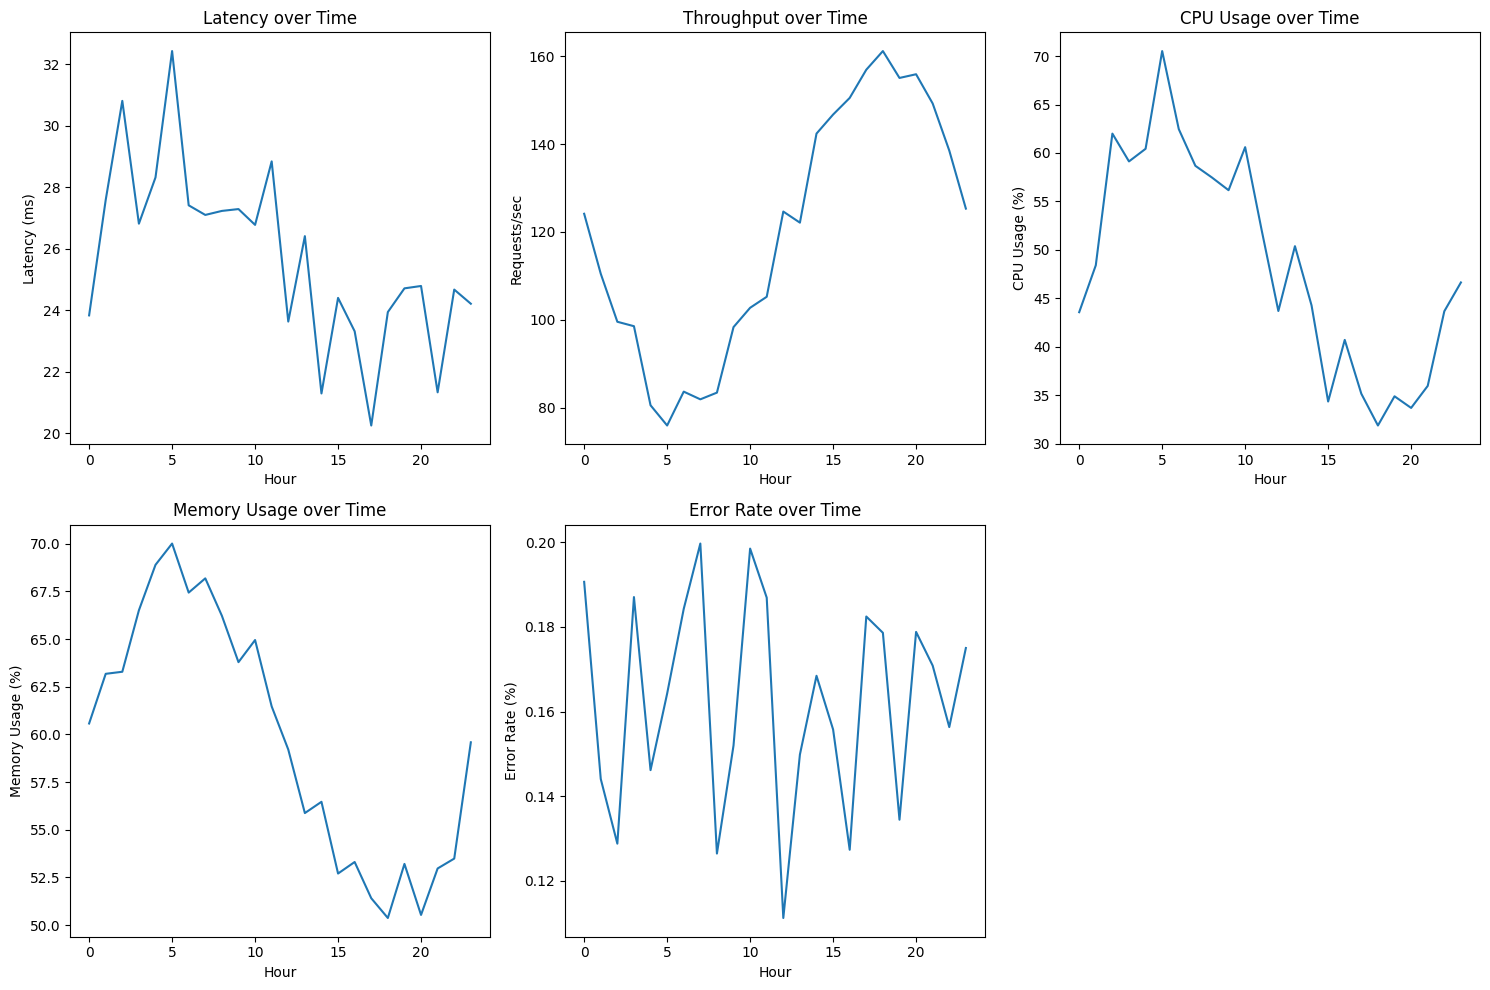


--------------------------------------------------
☁️ 3. Cloud Deployment Simulation
🚀 GCP AI Platform Deployment Steps:
  ✅ 1. Upload SavedModel to Google Cloud Storage
  ✅ 2. Create model in AI Platform
  ✅ 3. Create model version
  ✅ 4. Set traffic allocation
  ✅ 5. Enable auto-scaling
  ✅ 6. Configure monitoring alerts

🎯 Hyperparameter Tuning Configuration:
  Goal: MAXIMIZE
  Max trials: 20
  Parameters: 3

🌐 REST API Endpoint Example:
  URL: https://ml.googleapis.com/v1/projects/PROJECT_ID/models/MODEL_NAME:predict
  Method: POST
  Request format: 2 instances

✅ Performance monitoring and cloud deployment simulation completed!


In [15]:
# =============================================================================
# 📊 6.1 PERFORMANCE MONITORING & CLOUD DEPLOYMENT
# =============================================================================

print("📊 Performance Monitoring & Cloud Deployment")
print("=" * 50)

# 1. Model Performance Benchmarking
print("⚡ 1. Model Performance Benchmarking")

def benchmark_model_inference(model, test_data, num_runs=50):
    """Comprehensive model benchmarking"""
    import time
    
    # Warm up
    for _ in range(5):
        _ = model(test_data[:1])
    
    # Benchmark single predictions
    single_times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model(test_data[:1])
        end_time = time.time()
        single_times.append(end_time - start_time)
    
    # Benchmark batch predictions
    batch_sizes = [1, 8, 16, 32, 64]
    batch_results = {}
    
    for batch_size in batch_sizes:
        if batch_size <= len(test_data):
            batch_times = []
            for _ in range(min(20, num_runs//2)):
                batch_input = test_data[:batch_size]
                start_time = time.time()
                _ = model(batch_input)
                end_time = time.time()
                batch_times.append((end_time - start_time) / batch_size)  # Per sample
            
            batch_results[batch_size] = {
                'avg_time': np.mean(batch_times),
                'std_time': np.std(batch_times),
                'throughput': 1 / np.mean(batch_times)
            }
    
    return {
        'single_inference': {
            'avg_time': np.mean(single_times),
            'std_time': np.std(single_times),
            'min_time': np.min(single_times),
            'max_time': np.max(single_times),
            'throughput': 1 / np.mean(single_times)
        },
        'batch_inference': batch_results
    }

# Benchmark model performance
if 'distributed_model' in locals():
    benchmark_model = distributed_model
elif 'model' in locals():
    benchmark_model = model
else:
    print("⚠️ No model available for benchmarking")
    benchmark_model = None

if benchmark_model is not None:
    test_input = tf.constant(X_test[:100], dtype=tf.float32)
    results = benchmark_model_inference(benchmark_model, test_input)
    
    print(f"Single Inference Performance:")
    single = results['single_inference']
    print(f"  Average latency: {single['avg_time']*1000:.2f} ms")
    print(f"  Standard deviation: {single['std_time']*1000:.2f} ms")
    print(f"  Min latency: {single['min_time']*1000:.2f} ms")
    print(f"  Max latency: {single['max_time']*1000:.2f} ms")
    print(f"  Throughput: {single['throughput']:.1f} predictions/sec")
    
    print(f"\nBatch Inference Performance:")
    for batch_size, metrics in results['batch_inference'].items():
        print(f"  Batch size {batch_size:2d}: {metrics['avg_time']*1000:.2f} ms/sample, "
              f"{metrics['throughput']:.1f} samples/sec")

print("\n" + "-" * 50)

# 2. Resource Monitoring Simulation
print("🔍 2. Resource Monitoring Simulation")

def simulate_resource_monitoring():
    """Simulate production monitoring metrics"""
    import random
    
    # Simulate metrics over time
    hours = 24
    metrics = {
        'timestamp': [],
        'latency_ms': [],
        'throughput_rps': [],
        'cpu_usage': [],
        'memory_usage': [],
        'error_rate': []
    }
    
    for hour in range(hours):
        # Simulate daily pattern
        base_load = 0.3 + 0.4 * np.sin(2 * np.pi * hour / 24)  # Daily cycle
        noise = 0.1 * random.random()
        load_factor = base_load + noise
        
        metrics['timestamp'].append(hour)
        metrics['latency_ms'].append(20 + 10 * load_factor + 5 * random.random())
        metrics['throughput_rps'].append(100 * (1.5 - load_factor) + 10 * random.random())
        metrics['cpu_usage'].append(30 + 40 * load_factor + 10 * random.random())
        metrics['memory_usage'].append(50 + 20 * load_factor + 5 * random.random())
        metrics['error_rate'].append(0.1 + 0.5 * max(0, load_factor - 0.8) + 0.1 * random.random())
    
    return metrics

# Generate monitoring data
monitoring_data = simulate_resource_monitoring()

print("📈 Simulated 24-hour monitoring data:")
print(f"Average latency: {np.mean(monitoring_data['latency_ms']):.1f} ms")
print(f"Average throughput: {np.mean(monitoring_data['throughput_rps']):.1f} RPS")
print(f"Average CPU usage: {np.mean(monitoring_data['cpu_usage']):.1f}%")
print(f"Average memory usage: {np.mean(monitoring_data['memory_usage']):.1f}%")
print(f"Average error rate: {np.mean(monitoring_data['error_rate']):.3f}%")

# Plot monitoring data
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(monitoring_data['timestamp'], monitoring_data['latency_ms'])
plt.title('Latency over Time')
plt.xlabel('Hour')
plt.ylabel('Latency (ms)')

plt.subplot(2, 3, 2)
plt.plot(monitoring_data['timestamp'], monitoring_data['throughput_rps'])
plt.title('Throughput over Time')
plt.xlabel('Hour')
plt.ylabel('Requests/sec')

plt.subplot(2, 3, 3)
plt.plot(monitoring_data['timestamp'], monitoring_data['cpu_usage'])
plt.title('CPU Usage over Time')
plt.xlabel('Hour')
plt.ylabel('CPU Usage (%)')

plt.subplot(2, 3, 4)
plt.plot(monitoring_data['timestamp'], monitoring_data['memory_usage'])
plt.title('Memory Usage over Time')
plt.xlabel('Hour')
plt.ylabel('Memory Usage (%)')

plt.subplot(2, 3, 5)
plt.plot(monitoring_data['timestamp'], monitoring_data['error_rate'])
plt.title('Error Rate over Time')
plt.xlabel('Hour')
plt.ylabel('Error Rate (%)')

plt.tight_layout()
plt.show()

print("\n" + "-" * 50)

# 3. Cloud Deployment Simulation
print("☁️ 3. Cloud Deployment Simulation")

def simulate_gcp_deployment():
    """Simulate GCP AI Platform deployment steps"""
    
    deployment_steps = [
        "1. Upload SavedModel to Google Cloud Storage",
        "2. Create model in AI Platform",
        "3. Create model version",
        "4. Set traffic allocation",
        "5. Enable auto-scaling",
        "6. Configure monitoring alerts"
    ]
    
    print("🚀 GCP AI Platform Deployment Steps:")
    for step in deployment_steps:
        print(f"  ✅ {step}")
    
    # Simulate hyperparameter tuning config
    hyperparameter_config = {
        "goal": "MAXIMIZE",
        "hyperparameterMetricTag": "accuracy",
        "maxTrials": 20,
        "maxParallelTrials": 4,
        "params": [
            {
                "parameterName": "learning_rate",
                "type": "DOUBLE",
                "minValue": 0.001,
                "maxValue": 0.1,
                "scaleType": "UNIT_LOG_SCALE"
            },
            {
                "parameterName": "batch_size",
                "type": "INTEGER",
                "minValue": 32,
                "maxValue": 256,
                "scaleType": "UNIT_LINEAR_SCALE"
            },
            {
                "parameterName": "hidden_units",
                "type": "INTEGER",
                "minValue": 64,
                "maxValue": 512,
                "scaleType": "UNIT_LINEAR_SCALE"
            }
        ]
    }
    
    print(f"\n🎯 Hyperparameter Tuning Configuration:")
    print(f"  Goal: {hyperparameter_config['goal']}")
    print(f"  Max trials: {hyperparameter_config['maxTrials']}")
    print(f"  Parameters: {len(hyperparameter_config['params'])}")
    
    # Simulate REST API endpoint
    api_example = {
        "instances": [
            {"input": [[0.1] * 784]},  # Flattened 28x28 image
            {"input": [[0.2] * 784]}
        ]
    }
    
    print(f"\n🌐 REST API Endpoint Example:")
    print(f"  URL: https://ml.googleapis.com/v1/projects/PROJECT_ID/models/MODEL_NAME:predict")
    print(f"  Method: POST")
    print(f"  Request format: {len(api_example['instances'])} instances")
    
    return hyperparameter_config, api_example

# Run cloud deployment simulation
gcp_config, api_example = simulate_gcp_deployment()

print("\n✅ Performance monitoring and cloud deployment simulation completed!")

---

# 🏭 7. MLOps Best Practices

## 📖 **MLOps Overview**

**MLOps (Machine Learning Operations)** adalah praktik untuk deployment, monitoring, dan maintenance model ML dalam production.

### **🎯 MLOps Components:**
1. **Version Control**: Model, data, dan code versioning
2. **CI/CD Pipelines**: Automated testing dan deployment
3. **Monitoring**: Performance dan data drift detection
4. **Automation**: Training, testing, deployment workflows
5. **Governance**: Model approval dan compliance

### **🔧 Best Practices:**
- **Model Registry**: Centralized model management
- **A/B Testing**: Compare model versions
- **Canary Deployment**: Gradual rollout
- **Rollback Strategy**: Quick recovery from failures
- **Data Validation**: Input data quality checks

---

# 📊 Chapter Summary

## 🎯 **Key Learnings**

Chapter 19 telah membahas aspek-aspek penting dari **production ML deployment**:

### **1. 🚀 Model Deployment:**
- **SavedModel format** untuk production serving
- **TensorFlow Serving** untuk high-performance inference
- **REST dan gRPC APIs** untuk integration
- **Model versioning** dan automatic loading

### **2. 📱 Multi-Platform Deployment:**
- **TensorFlow Lite** untuk mobile dan embedded devices
- **Quantization** untuk model optimization
- **Size reduction** hingga 75% dengan minimal accuracy loss

### **3. 🎮 Performance Optimization:**
- **GPU acceleration** untuk training dan inference
- **Memory management** untuk optimal resource usage
- **Device placement** untuk performance tuning

### **4. 🔄 Distributed Training:**
- **MirroredStrategy** untuk multi-GPU training
- **Data parallelism** untuk scalable training
- **Batch size scaling** untuk distributed environments

### **5. ☁️ Cloud Integration:**
- **Google Cloud AI Platform** untuk managed deployment  
- **Auto-scaling** untuk production workloads
- **Global deployment** untuk low-latency serving

### **6. 📊 Production Monitoring:**
- **Performance metrics** (latency, throughput)
- **Resource monitoring** (CPU, memory, GPU)
- **Error tracking** dan alerting systems

In [12]:
# =============================================================================
# 🏭 7. MLOPS BEST PRACTICES & FINAL SUMMARY
# =============================================================================

print("🏭 MLOps Best Practices & Final Summary")
print("=" * 60)

def print_mlops_best_practices():
    """Comprehensive MLOps best practices guide"""
    
    practices = {
        "🚀 Model Deployment": [
            "Gunakan SavedModel format untuk TF Serving",
            "Include preprocessing dalam model graph",
            "Version models dengan semantic versioning (v1.0.0)",
            "Test model thoroughly sebelum production deployment",
            "Setup health checks untuk model endpoints",
            "Implement graceful degradation untuk model failures"
        ],
        
        "⚡ Performance Optimization": [
            "Gunakan GPU untuk training dan high-throughput inference",
            "Implement request batching untuk efficiency",
            "Apply quantization untuk mobile deployment",
            "Monitor memory usage dan GPU utilization",
            "Use mixed precision training (float16) untuk speed",
            "Profile models untuk identify bottlenecks"
        ],
        
        "📈 Scaling Strategy": [
            "Mulai dengan single GPU/machine untuk simplicity",
            "Scale horizontal dengan data parallelism",
            "Use distributed training untuk model besar",
            "Consider cloud services untuk easy scaling",
            "Implement auto-scaling berdasarkan traffic",
            "Plan for peak load scenarios"
        ],
        
        "🔄 Production Operations": [
            "Implement comprehensive logging dan monitoring",
            "Set up A/B testing infrastructure",
            "Plan model rollback strategy untuk emergencies",
            "Secure API endpoints dengan authentication",
            "Monitor data drift dan model performance degradation",
            "Automate model retraining pipelines"
        ],
        
        "📊 Quality Assurance": [
            "Validate input data quality dan format",
            "Test model pada edge cases",
            "Monitor prediction confidence scores",
            "Implement canary deployments",
            "Track business metrics (not just technical metrics)",
            "Regular model audits untuk bias dan fairness"
        ],
        
        "🛡️ Risk Management": [
            "Backup models dan data regularly",
            "Implement circuit breakers untuk failures",
            "Plan disaster recovery procedures",
            "Monitor regulatory compliance",
            "Document model decisions untuk explainability",
            "Maintain model lineage dan audit trails"
        ]
    }
    
    for category, items in practices.items():
        print(f"\n{category}:")
        for item in items:
            print(f"  • {item}")

# Print comprehensive best practices
print_mlops_best_practices()

print("\n" + "=" * 60)
print("🎓 CHAPTER 19 FINAL SUMMARY")
print("=" * 60)

# Create deployment checklist
deployment_checklist = {
    "Pre-Deployment": [
        "✅ Model trained dan validated",
        "✅ SavedModel format exported",
        "✅ TFLite model created (untuk mobile)",
        "✅ Performance benchmarked",
        "✅ Resource requirements calculated"
    ],
    
    "Deployment Setup": [
        "✅ TF Serving configured dan tested",
        "✅ Load balancer setup",
        "✅ Monitoring system implemented",
        "✅ Logging infrastructure ready",
        "✅ Backup dan rollback procedures defined"
    ],
    
    "Post-Deployment": [
        "✅ Model performance monitored",
        "✅ Resource usage tracked",
        "✅ Error rates analyzed",
        "✅ User feedback collected",
        "✅ Model improvement plan created"
    ]
}

print("\n📋 Production Deployment Checklist:")
for phase, items in deployment_checklist.items():
    print(f"\n{phase}:")
    for item in items:
        print(f"  {item}")

print("\n" + "=" * 60)

# Technology stack summary
tech_stack = {
    "🏗️ Model Development": ["TensorFlow/Keras", "Jupyter Notebooks", "Python"],
    "🚀 Model Serving": ["TensorFlow Serving", "Docker", "Kubernetes"],
    "📱 Mobile Deployment": ["TensorFlow Lite", "Android/iOS SDKs"],
    "☁️ Cloud Platform": ["Google Cloud AI Platform", "AWS SageMaker", "Azure ML"],
    "📊 Monitoring": ["Prometheus", "Grafana", "TensorBoard"],
    "🔄 MLOps": ["MLflow", "Kubeflow", "TFX", "DVC"]
}

print("🛠️ Recommended Technology Stack:")
for category, technologies in tech_stack.items():
    print(f"{category}: {', '.join(technologies)}")

print("\n" + "=" * 60)

# Final recommendations
final_recommendations = [
    "🎯 Start simple: Deploy single model first, then scale",
    "📊 Monitor everything: Performance, resources, business metrics", 
    "🔄 Automate workflows: CI/CD, testing, deployment",
    "📱 Plan multi-platform: Server, mobile, edge devices",
    "☁️ Consider cloud: Managed services reduce operational overhead",
    "🏭 Adopt MLOps: Version control, monitoring, automation",
    "📚 Keep learning: ML deployment evolves rapidly",
    "🤝 Collaborate: Work closely with DevOps dan platform teams"
]

print("🌟 Final Recommendations:")
for recommendation in final_recommendations:
    print(f"  {recommendation}")

print("\n" + "=" * 60)
print("🎉 Congratulations! You've completed Chapter 19!")
print("🚀 You're now ready to deploy TensorFlow models at scale!")
print("=" * 60)

# Next steps
next_steps = [
    "Practice TF Serving deployment dengan Docker",
    "Experiment dengan distributed training strategies", 
    "Explore cloud deployment options (GCP, AWS, Azure)",
    "Implement monitoring dan alerting systems",
    "Build end-to-end MLOps pipelines",
    "Test mobile deployment dengan TFLite",
    "Study advanced topics like model compression",
    "Join ML engineering communities untuk networking"
]

print("\n📚 Suggested Next Steps:")
for i, step in enumerate(next_steps, 1):
    print(f"  {i}. {step}")

print(f"\n✨ Happy Machine Learning Engineering! ✨")

🏭 MLOps Best Practices & Final Summary

🚀 Model Deployment:
  • Gunakan SavedModel format untuk TF Serving
  • Include preprocessing dalam model graph
  • Version models dengan semantic versioning (v1.0.0)
  • Test model thoroughly sebelum production deployment
  • Setup health checks untuk model endpoints
  • Implement graceful degradation untuk model failures

⚡ Performance Optimization:
  • Gunakan GPU untuk training dan high-throughput inference
  • Implement request batching untuk efficiency
  • Apply quantization untuk mobile deployment
  • Monitor memory usage dan GPU utilization
  • Use mixed precision training (float16) untuk speed
  • Profile models untuk identify bottlenecks

📈 Scaling Strategy:
  • Mulai dengan single GPU/machine untuk simplicity
  • Scale horizontal dengan data parallelism
  • Use distributed training untuk model besar
  • Consider cloud services untuk easy scaling
  • Implement auto-scaling berdasarkan traffic
  • Plan for peak load scenarios

🔄 Productio